# Analysis of the AMLTK Pipeline
We compare 10 trials on the original data vs. for each feature engineering methods 10 trials on feature-engineered data by OpenFE and other AutoML systems doing feature engineering (like lightautoml, h2o or autofeat) on different datasets.

### Imports

In [148]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from cycler import cycler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Sneak

In [149]:
df = pd.read_parquet("results.parquet")
df.head()

,status,trial_seed,exception,traceback,bucket,created_at,reported_at,"metric:accuracy [0.0, 1.0] (maximize)",summary:split_0:val_accuracy,summary:split_0:train_accuracy,...,profile:cv:train_score:memory:diff_vms,profile:cv:train_score:memory:start_rss,profile:cv:train_score:memory:end_rss,profile:cv:train_score:memory:diff_rss,profile:cv:train_score:memory:unit,profile:cv:train_score:time:start,profile:cv:train_score:time:end,profile:cv:train_score:time:duration,profile:cv:train_score:time:kind,profile:cv:train_score:time:unit
name,,,,,,,,,,,,,,,,,,,,,
trial-F4ne-4,success,42,NA,NA,/Users/schaefer.bastian/Programming/ALU/Master...,2024-05-08 08:19:46.643985,2024-05-08 08:19:55.374789,0.651627,0.617647,0.661017,...,0,323584000,323584000,0,bytes,1715149195.247042,1715149195.290437,0.043395,wall,seconds
trial-PhYq-2,success,42,NA,NA,/Users/schaefer.bastian/Programming/ALU/Master...,2024-05-08 08:19:46.643718,2024-05-08 08:19:55.567327,0.640486,0.617647,0.65678,...,0,323502080,323502080,0,bytes,1715149195.438928,1715149195.481608,0.04268,wall,seconds
trial-5JTG-3,success,42,NA,NA,/Users/schaefer.bastian/Programming/ALU/Master...,2024-05-08 08:19:46.643849,2024-05-08 08:19:55.852116,0.622103,0.617647,0.699153,...,0,323485696,323485696,0,bytes,1715149195.73187,1715149195.772815,0.040945,wall,seconds
trial-FOyc-1,success,42,NA,NA,/Users/schaefer.bastian/Programming/ALU/Master...,2024-05-08 08:19:46.643541,2024-05-08 08:19:57.519880,0.68115,0.647059,0.868644,...,0,323780608,323780608,0,bytes,1715149197.38918,1715149197.435809,0.046629,wall,seconds
trial-iyEK-6,success,42,NA,NA,/Users/schaefer.bastian/Programming/ALU/Master...,2024-05-08 08:19:55.569520,2024-05-08 08:20:00.233095,0.625891,0.617647,0.661017,...,0,324419584,324419584,0,bytes,1715149200.108073,1715149200.150597,0.042524,wall,seconds


In [153]:
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
part_size = 10

df['index_col'] = np.arange(len(df))

# Get number of label, that has to be removed because the execution failed
failed_trials = []
for index in df['index_col']:
    if df["status"][index] == "fail":
        failed_trials.append(index)
failed_trials = [int(x / part_size) for x in failed_trials]
failed_trials = list(set(failed_trials))

# Remove failed Trials
df_success = df[df["status"] != "fail"]

# Define how many different methods we used (original data, openfe data, self-feature-engineered data, ...)
total_parts = int(df_success.shape[0] / part_size)

# Give every method a color in the plot
colors = [hsv_to_rgb([(i * 0.618033988749895) % 1.0, 1, 1]) for i in range(total_parts)] 

# Define label for every method and remove them automatically if one of them failed (has to be in the right order)
label_list = ['Original Data', 'Self-feature-engineered Data', 'autofeat Data', 'OpenFE Data']
removed_label_list = []
for elem in failed_trials:
    removed_label_list.append(label_list[elem])
    label_list.pop(elem)

### Status

In [154]:
# Print minutes passed since execution (to check if results are the latest)
executed = df_success["created_at"][0]
now = datetime.now()
duration = now - executed
duration_in_s = duration.total_seconds()
minutes = divmod(duration_in_s, 60)[0]
print("The parquet was executed " + str(minutes) + " minutes ago.")
# Print all successful trials
print(df_success["status"].to_string(index=1))

The parquet was executed 439.0 minutes ago.
name
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-iyEK-6     success
trial-gTHU-5     success
trial-cw0K-7     success
trial-WWSZ-8     success
trial-x65t-9     success
trial-7MpJ-10    success
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-gTHU-5     success
trial-iyEK-6     success
trial-WWSZ-8     success
trial-cw0K-7     success
trial-x65t-9     success
trial-7MpJ-10    success
trial-F4ne-4     success
trial-PhYq-2     success
trial-5JTG-3     success
trial-FOyc-1     success
trial-iyEK-6     success
trial-gTHU-5     success
trial-cw0K-7     success
trial-WWSZ-8     success
trial-x65t-9     success
trial-7MpJ-10    success


In [157]:
# Get error message for failed trials
i = 0
for failed_trial in failed_trials:
    print("Error at " + str(removed_label_list[i]))
    print("Traceback : \n" + str(df["traceback"][failed_trial * part_size]) + "\n\n")
    i += 1

Error at autofeat Data
Traceback : 
Traceback (most recent call last):
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 747, in cross_validate_task
    for i, _split_eval in trial.profiler.each(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/profiling/profiler.py", line 279, in each
    for i, item in enumerate(itr):
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 551, in _iter_cross_validate
    yield _evaluate_split(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/amltk/sklearn/evaluation.py", line 491, in _evaluate_split
    test_scores = _score(
  File "/Users/schaefer.bastian/miniconda3/envs/Masterarbeit/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **

### Metric Accuracy

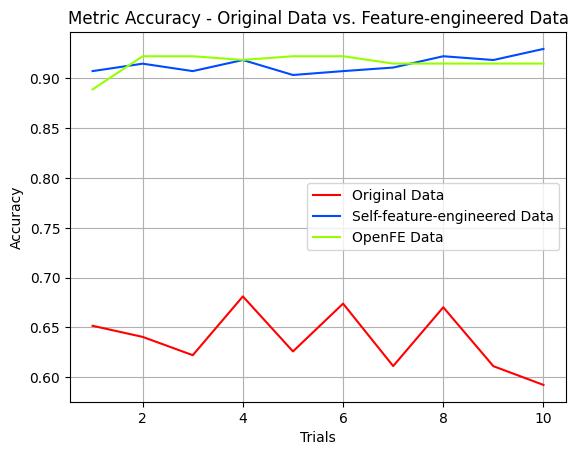

In [137]:
metric_accuracy = df_success["metric:accuracy [0.0, 1.0] (maximize)"].tolist()
data_parts = [metric_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Metric Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/metric_accuracy.png')
plt.show()

### Train, Val and Test Accuracy over all Splits

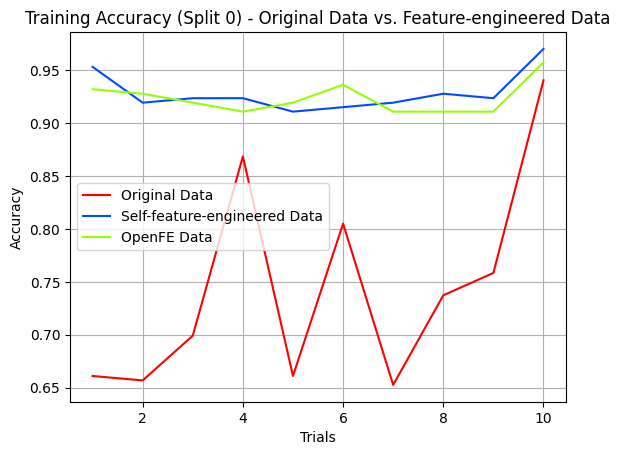

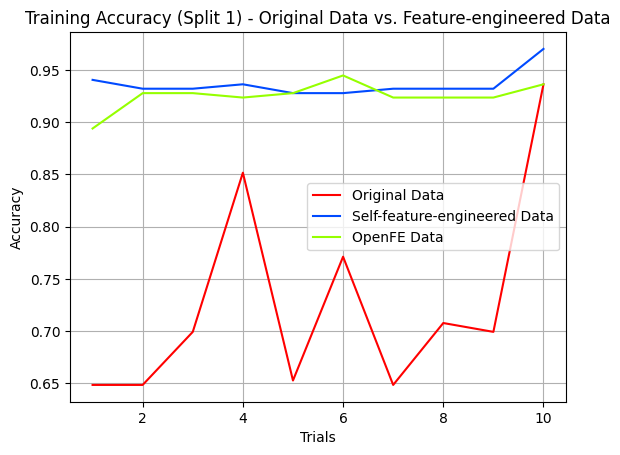

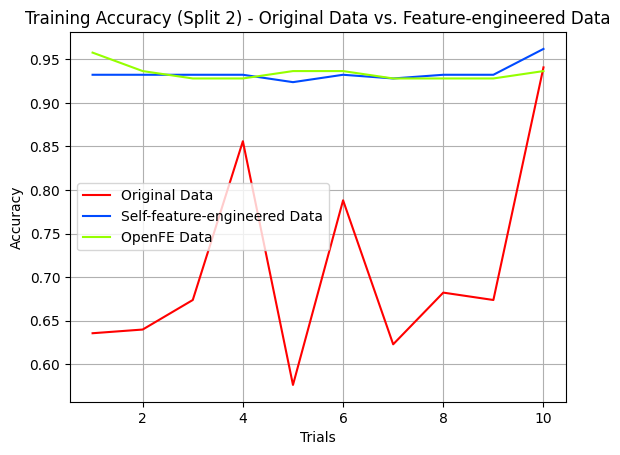

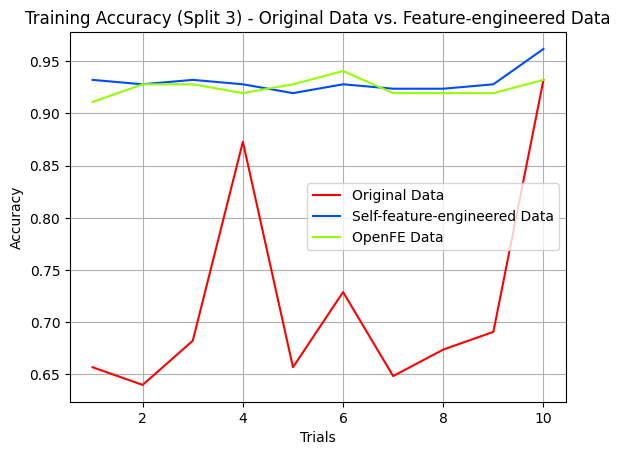

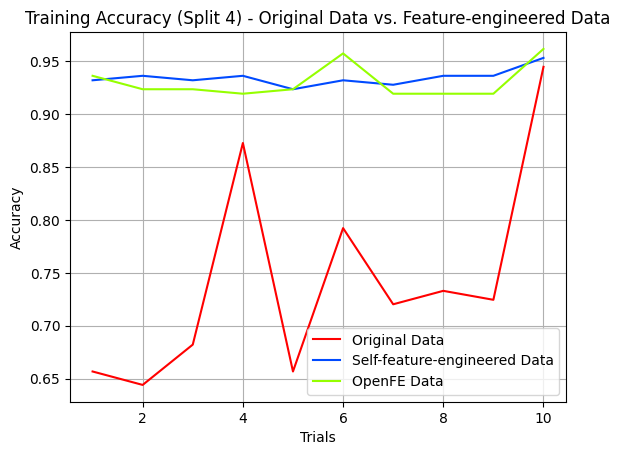

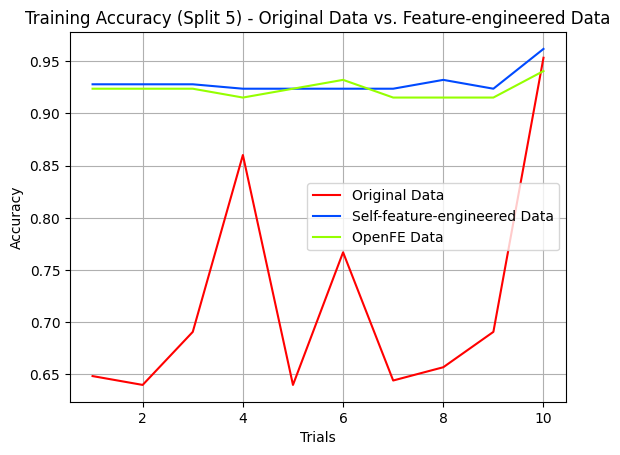

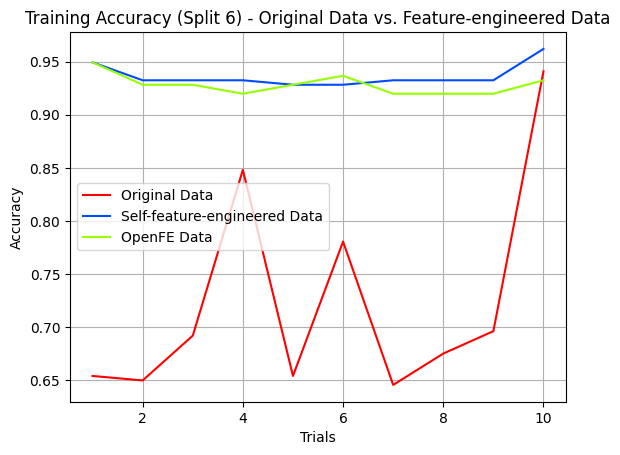

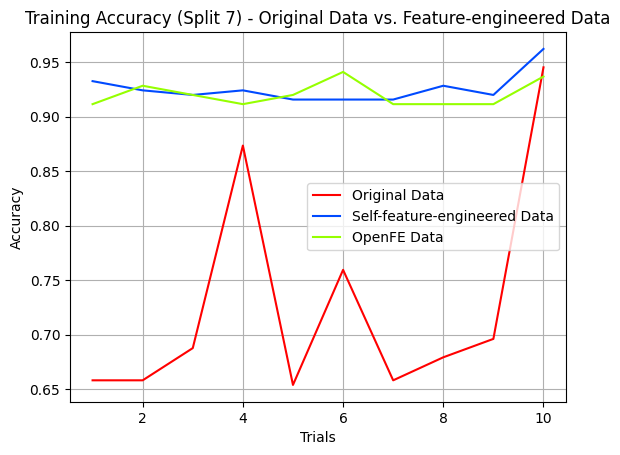

In [130]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":train_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
j = 0
for dataset_name in dataset_names:
    train_accuracy = df_success[dataset_name].tolist()
    data_parts = [train_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    for i, data_part in enumerate(data_parts):
        label = label_list[i]
        plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Training Accuracy (Split " + str(j) + ") - Original Data vs. Feature-engineered Data")
    plt.legend()
    plt.grid(True)
    plt.show()
    j += 1

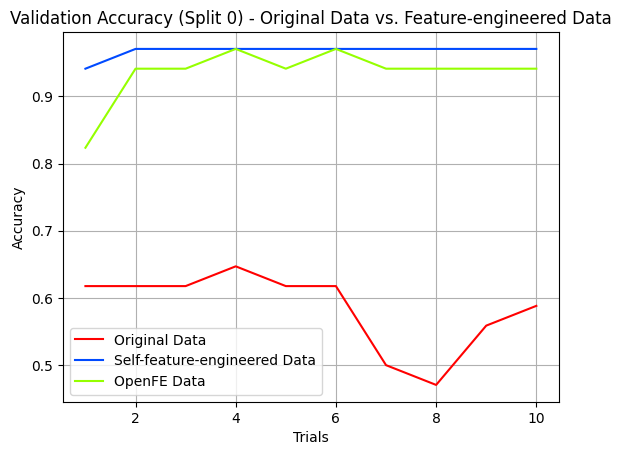

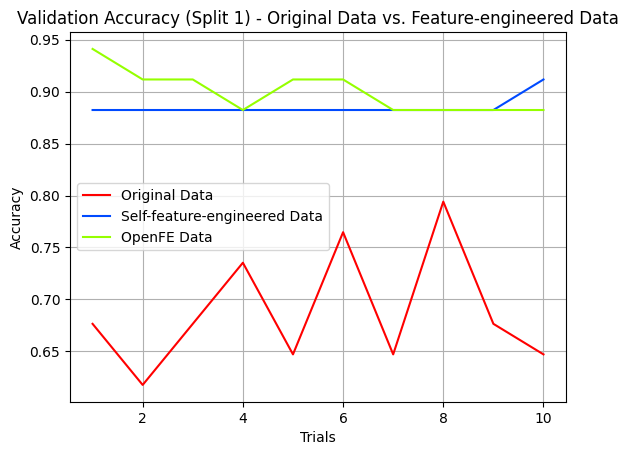

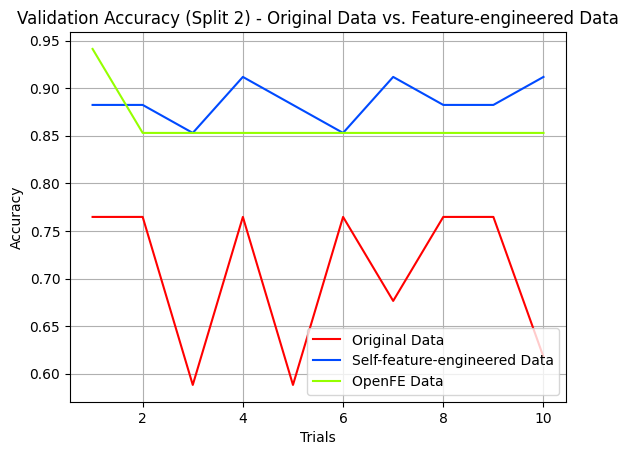

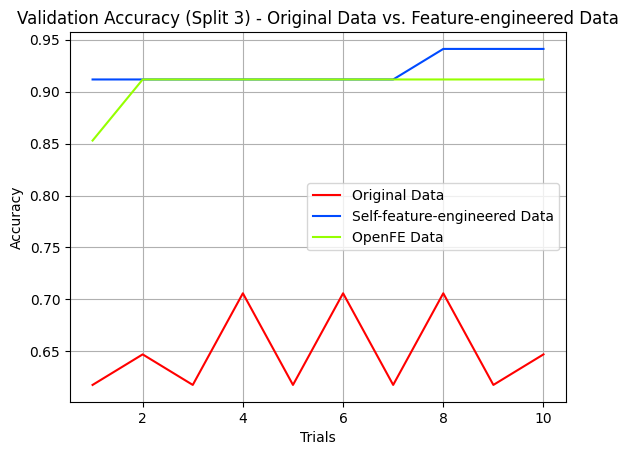

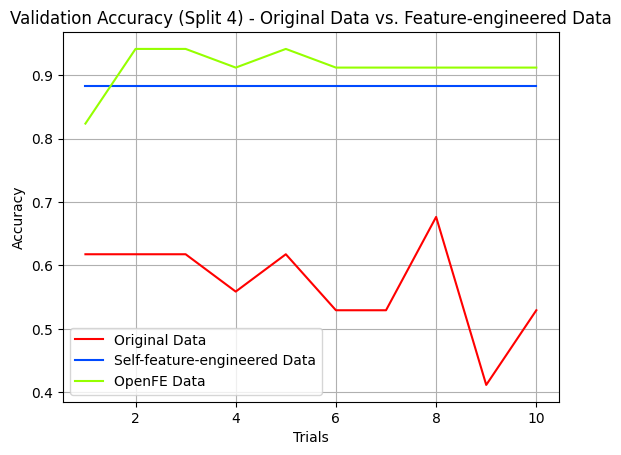

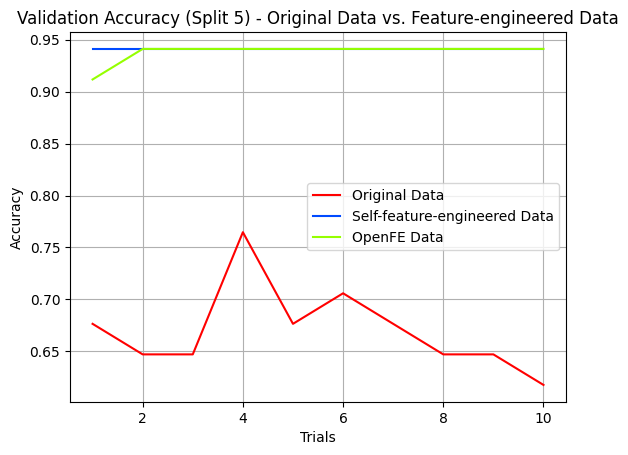

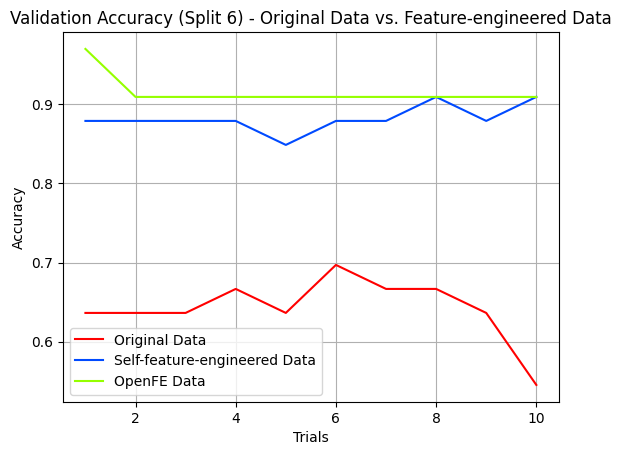

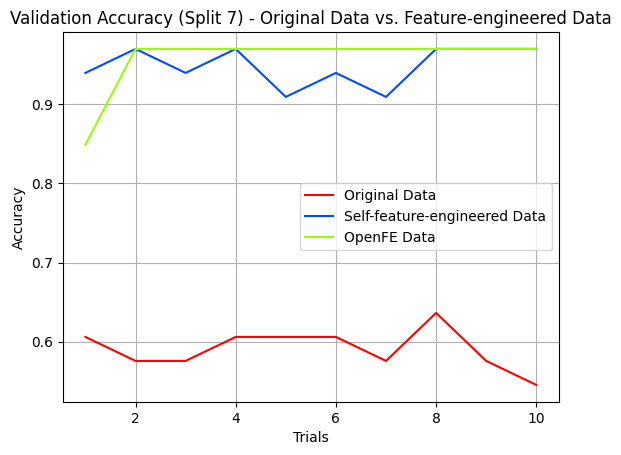

In [131]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":val_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
j = 0
for dataset_name in dataset_names:
    val_accuracy = df_success[dataset_name].tolist()
    data_parts = [val_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    for i, data_part in enumerate(data_parts):
        label = label_list[i]
        plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Validation Accuracy (Split " + str(j) + ") - Original Data vs. Feature-engineered Data")
    plt.legend()
    plt.grid(True)
    plt.show()
    j += 1

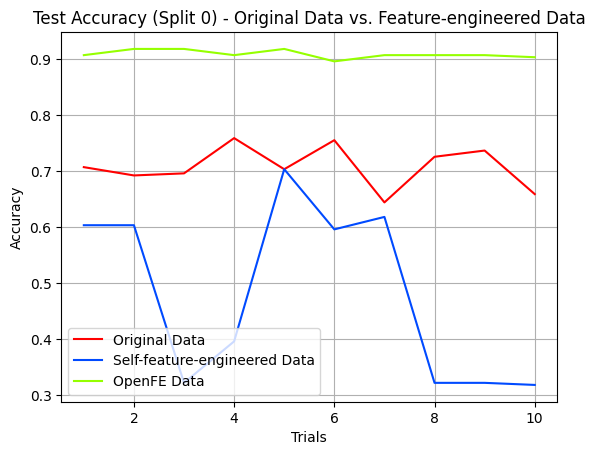

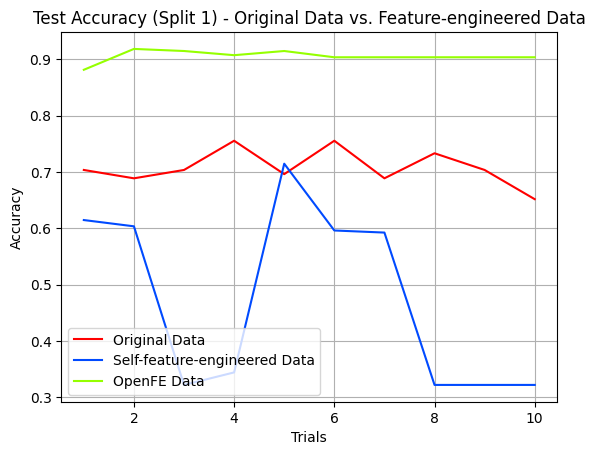

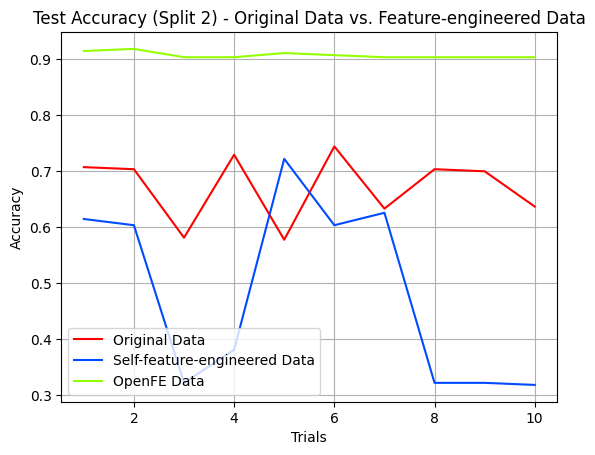

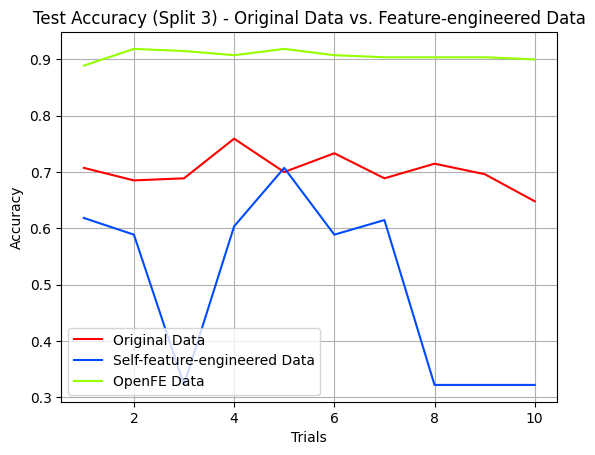

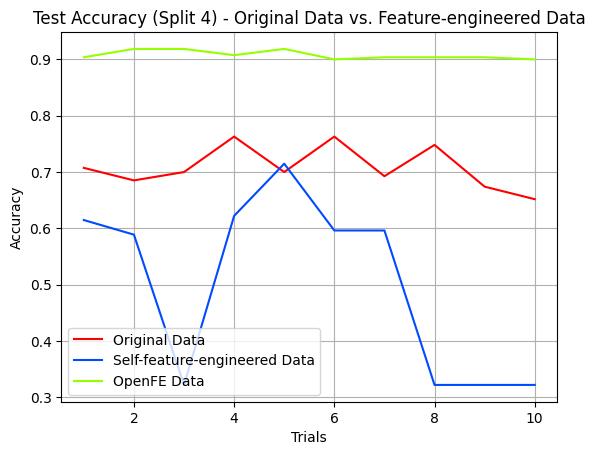

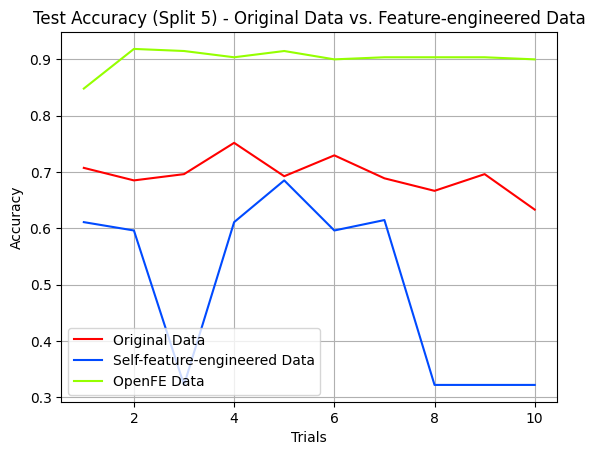

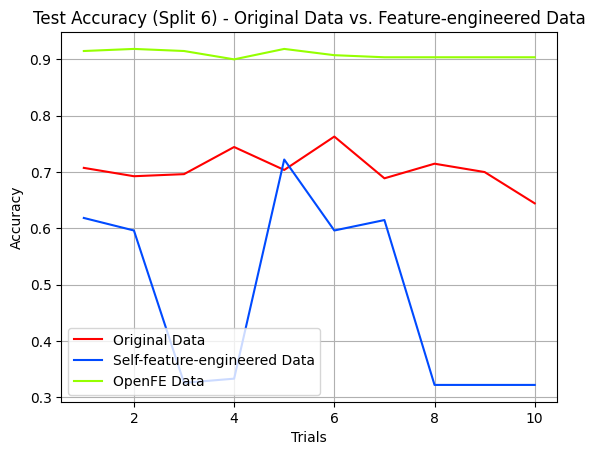

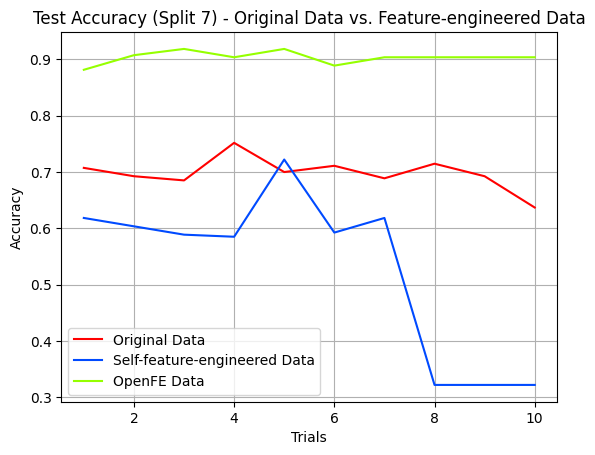

In [132]:
dataset_names = []
for i in range(8):
    dataset_name = "summary:split_" + str(i) + ":test_accuracy"
    dataset_names.append(dataset_name)

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
j = 0
for dataset_name in dataset_names:
    test_accuracy = df_success[dataset_name].tolist()
    data_parts = [test_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
    for i, data_part in enumerate(data_parts):
        label = label_list[i]
        plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
    plt.xlabel("Trials") 
    plt.ylabel("Accuracy") 
    plt.title("Test Accuracy (Split " + str(j) + ") - Original Data vs. Feature-engineered Data")
    plt.legend()
    plt.grid(True)
    plt.show()
    j += 1

### Mean and Std Accuracy (Train, Val and Test)

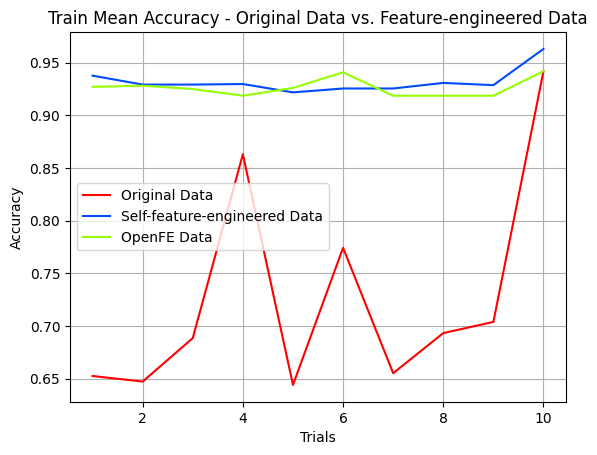

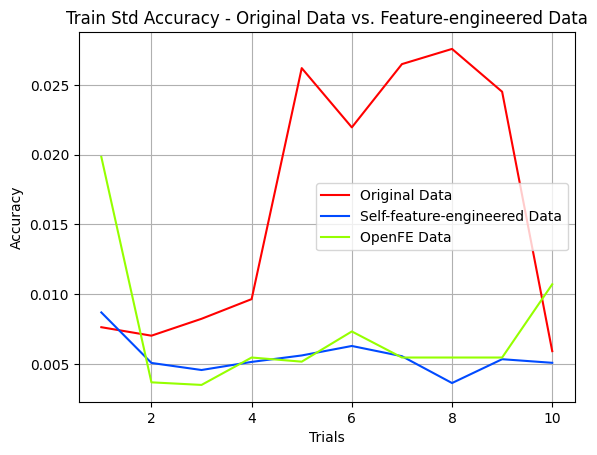

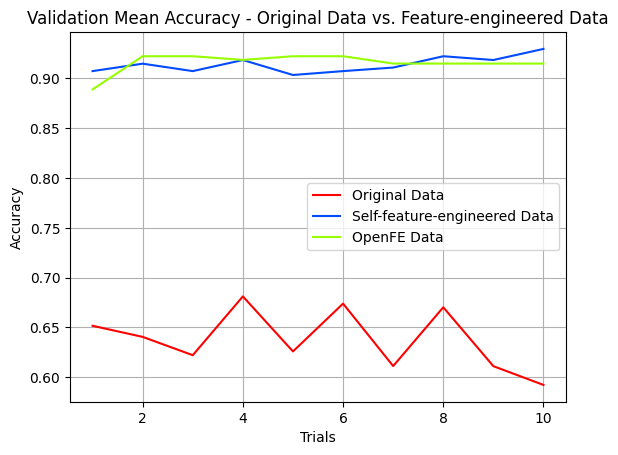

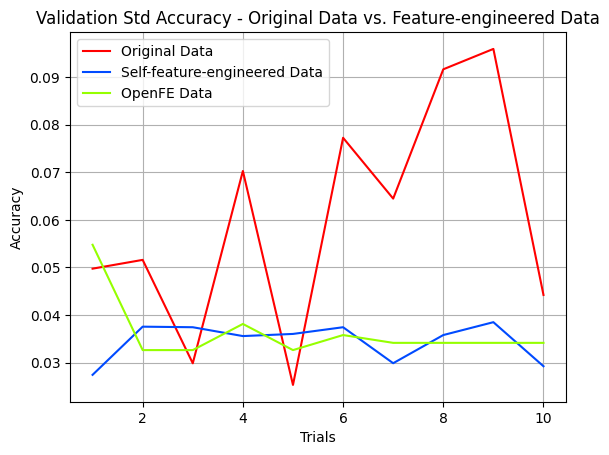

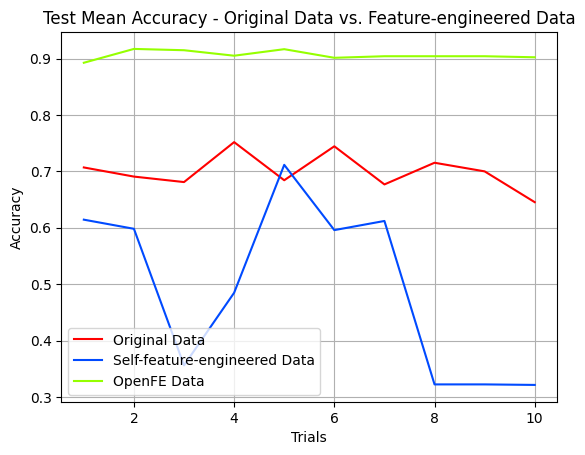

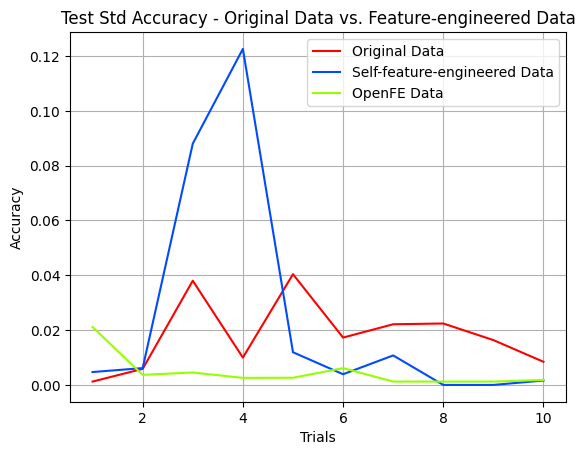

In [133]:
dataset_names = ["summary:train_mean_accuracy", "summary:train_std_accuracy", "summary:val_mean_accuracy", "summary:val_std_accuracy", "summary:test_mean_accuracy", "summary:test_std_accuracy"]
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_mean_accuracy = df_success[dataset_names[0]].tolist()
data_parts = [train_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Train Mean Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/train_mean_accuracy.png')
plt.show()

train_std_accuracy = df_success[dataset_names[1]].tolist()
data_parts = [train_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Train Std Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/train_std_accuracy.png')
plt.show()

val_mean_accuracy = df_success[dataset_names[2]].tolist()
data_parts = [val_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Validation Mean Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/val_mean_accuracy.png')
plt.show()

val_std_accuracy = df_success[dataset_names[3]].tolist()
data_parts = [val_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Validation Std Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/val_std_accuracy.png')
plt.show()

test_mean_accuracy = df_success[dataset_names[4]].tolist()
data_parts = [test_mean_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Test Mean Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/test_mean_accuracy.png')
plt.show()

test_std_accuracy = df_success[dataset_names[5]].tolist()
data_parts = [test_std_accuracy[i*part_size: (i+1)*part_size] for i in range(total_parts)]
for i, data_part in enumerate(data_parts):
    label = label_list[i]
    plt.plot(trials[:part_size], data_part, color=colors[i], label=label)
plt.xlabel("Trials") 
plt.ylabel("Accuracy") 
plt.title("Test Std Accuracy - Original Data vs. Feature-engineered Data")
plt.legend()
plt.grid(True)
plt.savefig('plots/test_std_accuracy.png')
plt.show()